# Background

This notebook simulates data in an equivalent way to NICE's R code. It then conducts the same MAIC methodology in Python.

Rmarkdown notebooks NICE's worked example in R:
- [NICE_DSU_Technical_Support_Document-Appendix_D](../R)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
np.random.seed(0)

# Data Preparation

## Define study characteristics and outcome model

In [3]:
N_AB, N_AC = 500, 300
minage_AB, minage_AC = 45, 45
maxage_AB, maxage_AC = 75, 55
femalepc_AB, femalepc_AC = 0.64, 0.8

b_0 = 0.85
b_gender = 0.12
b_age = 0.05
b_age_trt = -0.08
b_trt_B, b_trt_C = -2.1, -2.5

## Generate AB trial data

In [4]:
# generate A arm
AB_IPD = pd.DataFrame.from_dict(
    {
        "id": [p for p in range(int(N_AB / 2))],
        "age": np.random.randint(minage_AB, maxage_AB, int(N_AB / 2)),
        "gender": [
            1 if np.random.random() > femalepc_AB else 0 for _ in range(int(N_AB / 2))
        ],
        "trt": ["A"] * int(N_AB / 2),
    }
)
# generate B arm
AB_IPD = pd.concat(
    [
        AB_IPD,
        pd.DataFrame.from_dict(
            {
                "id": [p + int(N_AB / 2) for p in range(int(N_AB / 2))],
                "age": np.random.randint(minage_AB, maxage_AB, int(N_AB / 2)),
                "gender": [
                    1 if np.random.random() > femalepc_AB else 0
                    for _ in range(int(N_AB / 2))
                ],
                "trt": ["B"] * int(N_AB / 2),
            }
        ),
    ],
    ignore_index=True,
)
# generate outcomes
def yprob(x):
    t = b_0 + b_gender * x["gender"] + b_age * (x["age"] - 40)
    if x["trt"] == "B":
        t += b_trt_B + b_age_trt * (x["age"] - 40)
    elif x["trt"] == "C":
        t += b_trt_C + b_age_trt * (x["age"] - 40)
    return 1 / (1 + np.exp(-t))


AB_IPD["yprob"] = AB_IPD.apply(yprob, axis=1)
AB_IPD["y"] = AB_IPD["yprob"].apply(lambda x: np.random.binomial(1, x))
AB_IPD.drop("yprob", axis=1, inplace=True)

print(AB_IPD.sample(10))
AB_IPD.groupby("trt").agg(
    count=pd.NamedAgg(column="id", aggfunc="count"),
    mean_age=pd.NamedAgg(column="age", aggfunc="mean"),
    sd_age=pd.NamedAgg(column="age", aggfunc="std"),
    n_male=pd.NamedAgg(column="gender", aggfunc="sum"),
    pc_male=pd.NamedAgg(column="gender", aggfunc="mean"),
    sum_y=pd.NamedAgg(column="y", aggfunc="sum"),
    pc_y=pd.NamedAgg(column="y", aggfunc="mean"),
)

      id  age  gender trt  y
103  103   65       0   A  1
441  441   51       0   B  0
44    44   74       1   A  1
192  192   58       0   A  1
445  445   57       0   B  0
410  410   61       1   B  0
24    24   69       0   A  1
424  424   74       1   B  0
368  368   71       0   B  0
396  396   59       0   B  0


,count,mean_age,sd_age,n_male,pc_male,sum_y,pc_y
trt,,,,,,,
A,250,58.636,8.641888,90,0.36,220,0.880
B,250,59.508,8.817308,85,0.34,41,0.164


## Generate AC trial data

In [5]:
# generate A arm
AC_IPD = pd.DataFrame.from_dict(
    {
        "id": [p for p in range(int(N_AC / 2))],
        "age": np.random.randint(minage_AC, maxage_AC, int(N_AC / 2)),
        "gender": [
            1 if np.random.random() > femalepc_AC else 0 for _ in range(int(N_AC / 2))
        ],
        "trt": ["A"] * int(N_AC / 2),
    }
)
# generate C arm
AC_IPD = pd.concat(
    [
        AC_IPD,
        pd.DataFrame.from_dict(
            {
                "id": [p for p in range(int(N_AC / 2))],
                "age": np.random.randint(minage_AC, maxage_AC, int(N_AC / 2)),
                "gender": [
                    1 if np.random.random() > femalepc_AC else 0
                    for _ in range(int(N_AC / 2))
                ],
                "trt": ["C"] * int(N_AC / 2),
            }
        ),
    ],
    ignore_index=True,
)
# generate outcomes
AC_IPD["yprob"] = AC_IPD.apply(yprob, axis=1)
AC_IPD["y"] = AC_IPD["yprob"].apply(lambda x: np.random.binomial(1, x))
AC_IPD.drop("yprob", axis=1, inplace=True)

print(AC_IPD.sample(10))
AC_IPD.groupby("trt").agg(
    count=pd.NamedAgg(column="id", aggfunc="count"),
    mean_age=pd.NamedAgg(column="age", aggfunc="mean"),
    sd_age=pd.NamedAgg(column="age", aggfunc="std"),
    n_male=pd.NamedAgg(column="gender", aggfunc="sum"),
    pc_male=pd.NamedAgg(column="gender", aggfunc="mean"),
    sum_y=pd.NamedAgg(column="y", aggfunc="sum"),
    pc_y=pd.NamedAgg(column="y", aggfunc="mean"),
)

      id  age  gender trt  y
115  115   46       0   A  1
93    93   49       0   A  1
21    21   47       0   A  1
128  128   47       0   A  1
81    81   51       1   A  1
18    18   50       0   A  0
60    60   46       1   A  1
127  127   50       0   A  0
195   45   52       0   C  0
74    74   45       0   A  1


,count,mean_age,sd_age,n_male,pc_male,sum_y,pc_y
trt,,,,,,,
A,150,49.420000,2.862087,32,0.213333,113,0.753333
C,150,49.513333,2.911990,26,0.173333,22,0.146667


In [6]:
# compute aggregated data for AC trial
AC_AgD = AC_IPD[["age"]].mean()
AC_AgD["age_sd"] = AC_IPD["age"].std()
AC_AgD["n_male"] = AC_IPD["gender"].sum()
AC_AgD["pc_male"] = AC_IPD["gender"].mean()
AC_AgD["y_A_sum"] = AC_IPD.query("trt == 'A'")["y"].sum()
AC_AgD["y_A_mean"] = AC_IPD.query("trt == 'A'")["y"].mean()
AC_AgD["n_A"] = AC_IPD.query("trt == 'A'")["id"].count()
AC_AgD["y_C_sum"] = AC_IPD.query("trt == 'C'")["y"].sum()
AC_AgD["y_C_mean"] = AC_IPD.query("trt == 'C'")["y"].mean()
AC_AgD["n_C"] = AC_IPD.query("trt == 'C'")["id"].count()

AC_AgD

age          49.466667
age_sd        2.882694
n_male       58.000000
pc_male       0.193333
y_A_sum     113.000000
y_A_mean      0.753333
n_A         150.000000
y_C_sum      22.000000
y_C_mean      0.146667
n_C         150.000000
dtype: float64

# MAIC

In [7]:
def objfn(a1, X):
    return np.sum(np.exp(np.matmul(X, a1)))


def gradfn(a1, X):
    return np.dot(np.exp(np.matmul(X, a1)), X)


X_EM_0 = AB_IPD[["age"]].copy()
X_EM_0["age2"] = X_EM_0["age"] ** 2
X_EM_0["age"] = X_EM_0["age"] - AC_AgD["age"]
X_EM_0["age2"] = X_EM_0["age2"] - (AC_AgD["age"] ** 2 + AC_AgD["age_sd"] ** 2)

In [8]:
# https://machinelearningmastery.com/bfgs-optimization-in-python/
from scipy.optimize import minimize

result = minimize(objfn, (0, 0), method="BFGS", jac=gradfn, args=(X_EM_0))
result

      fun: 200.76228478845096
 hess_inv: array([[ 4.09152553e-01, -4.05622518e-03],
       [-4.05622518e-03,  4.02712868e-05]])
      jac: array([-9.22843846e-09, -4.37125436e-07])
  message: 'Optimization terminated successfully.'
     nfev: 23
      nit: 17
     njev: 23
   status: 0
  success: True
        x: array([ 3.92447929, -0.04001556])

count    5.000000e+02
mean     1.000000e+00
std      1.313263e+00
min      5.180574e-11
25%      3.493834e-05
50%      6.589685e-02
75%      2.004412e+00
max      3.498550e+00
dtype: float64


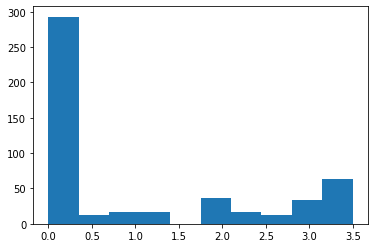

In [9]:
a1 = result.x
wt = np.exp(np.matmul(X_EM_0, a1))
wt_rs = wt / np.sum(wt) * N_AB
print(wt_rs.describe())
plt.hist(wt_rs);

In [10]:
ESS = np.sum(wt) ** 2 / sum(wt ** 2)
ESS

183.74173046439876

In [11]:
age_mean = (AB_IPD["age"] * wt_rs).mean()
age_sd = np.sqrt(np.sum((wt / np.sum(wt)) * (AB_IPD["age"] - age_mean) ** 2))
age_mean, age_sd

(49.4666666666207, 2.882693525934777)

In [12]:
list(AC_AgD[["age", "age_sd"]].values)

[49.46666666666667, 2.8826935255236337]

## Binomial GLM

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

AB_IPD["y0"] = 1 - AB_IPD["y"]

mod = smf.glm(
    "y + y0 ~ trt", freq_weights=wt, family=sm.families.Binomial(), data=AB_IPD
).fit(cov_type="HC3")
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            ['y', 'y0']   No. Observations:                  500
Model:                            GLM   Df Residuals:                   198.76
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -99.942
Date:                Sat, 08 Jan 2022   Deviance:                       199.88
Time:                        14:37:03   Pearson chi2:                     201.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1428
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6330      0.269      6.079      0.000       1.107       2.160
trt[T.B]      -2.7843      0.357     -7.804      0.000      -3.483      -2.085
==============================================================================
"""

In [14]:
d_AB_MAIC = mod.params["trt[T.B]"]
d_AB_MAIC

-2.7842576204210543

In [15]:
var_d_AB_MAIC = mod.cov_params_default[1][1]

In [16]:
AC_AgD

age          49.466667
age_sd        2.882694
n_male       58.000000
pc_male       0.193333
y_A_sum     113.000000
y_A_mean      0.753333
n_A         150.000000
y_C_sum      22.000000
y_C_mean      0.146667
n_C         150.000000
dtype: float64

In [17]:
d_AC = np.log(
    AC_AgD["y_C_sum"]
    * (AC_AgD["n_A"] - AC_AgD["y_A_sum"])
    / (AC_AgD["y_A_sum"] * (AC_AgD["n_C"] - AC_AgD["y_C_sum"]))
)
var_d_AC = (
    1 / AC_AgD["y_A_sum"]
    + 1 / (AC_AgD["n_A"] - AC_AgD["y_A_sum"])
    + 1 / AC_AgD["y_C_sum"]
    + 1 / (AC_AgD["n_C"] - AC_AgD["y_C_sum"])
)
d_B_MAIC = d_AC - d_AB_MAIC
d_B_MAIC

-0.093200096208363

In [18]:
var_d_BC_MAIC = var_d_AC + var_d_AB_MAIC
var_d_BC_MAIC

0.21641992006967337